In [1]:
import numpy as np
%matplotlib notebook
import pylab as plt
import pickle as pickle

import networkx as nx

from NAQ_graphs import NAQ

#for automatic graph generation
import yaml as yaml
from graph_generator import generate_graph
import os as os

/home/arnaudon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


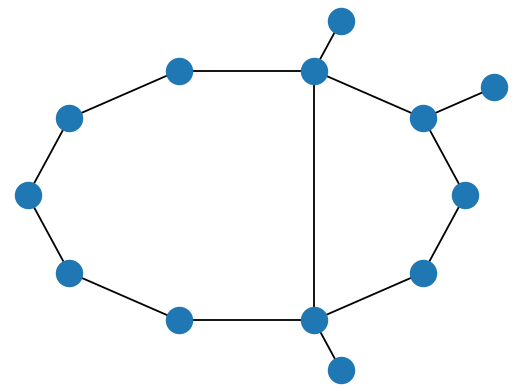

In [2]:
#create a small world network, using automatic generation, see generate_graph and graph_params for more

graph_tpe = 'SM'
params = yaml.load(open('graph_params.yaml','rb'))[graph_tpe]

G, pos  = generate_graph(tpe=graph_tpe, params = params)

if not os.path.isdir(graph_tpe):
    os.mkdir(graph_tpe)
os.chdir(graph_tpe)

#plot the graph
plt.figure(figsize=(4,3))
nx.draw(G, pos=pos, node_size=200)

In [3]:
#setup the main object
chi = np.array([ 1.j for i in range(len(G.edges))])

naq_u1 = NAQ(G, positions = pos, chi = chi, group = 'U1', open_graph = True)

naq_u1.n_processes_scan = 4 #number of CPU to use

#random update
naq_u1.update_chi([1.,1.])

#construct the graph laplacian
naq_u1.update_laplacian()

Total lenght: 8.082452920089256
Average lenght: 0.7347684472808415


In [4]:
#load the modes found in test_NAQ_U1_open.ipynb
modes = pickle.load(open('modes.pkl', 'rb'))
Ks, Alphas, s = pickle.load( open('scan.pkl', 'rb'))

<IPython.core.display.Javascript object>


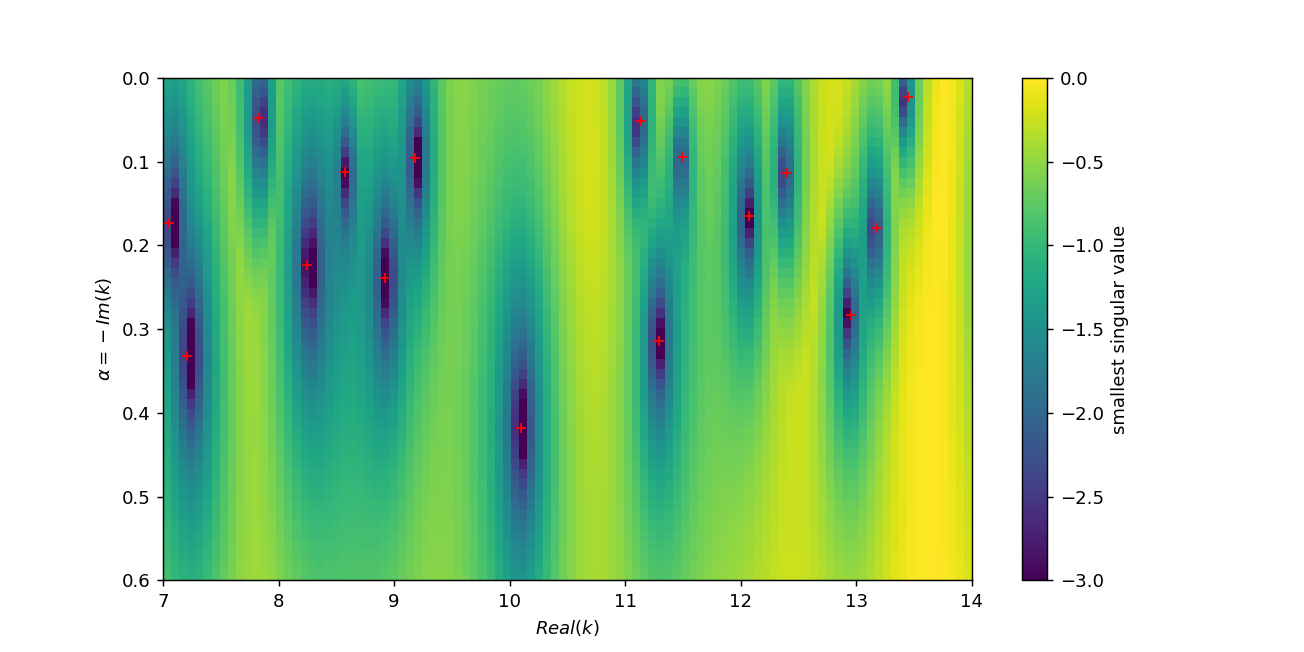

In [5]:
#plot the scan and modes
naq_u1.plot_scan(Ks,Alphas,s,modes)


In [6]:
#pump parameters (see SALT papers)
naq_u1.pump_params = {}
naq_u1.pump_params['gamma_perp'] = 100.
naq_u1.pump_params['k_a']        = 10.
naq_u1.pump_params['D0']         = 0 
naq_u1.pump_params['edges']      = [0, 1, 2, 3, 4, 5, 10]  #edges to pump

m = 0
naq_u1.update_chi(modes[m])
print("condition number no pump:", naq_u1.test_laplacian())

naq_u1.pump_params['D0']         = 1e-2
naq_u1.update_chi(modes[m])
print("condition number with pump:", naq_u1.test_laplacian())


condition number no pump: 0.0004521141
condition number with pump: 0.7224667


In [13]:
#find the pump trajectories
params['s_size']    = 1e-3*np.asarray([1.,1.])

#the correct balaance between s_size and the D0 steps must be found for each graph/pump
D0_max = .02
D0_steps = 10

new_modes = naq_u1.pump_trajectories(modes, params, D0_max = D0_max, D0_steps = D0_steps)

100%|██████████| 9/9 [00:37<00:00,  4.25s/it]


In [14]:

def plot_pump_traj(self, Ks, Alphas, s, modes, new_modes, estimate = False):
        self.plot_scan(Ks,Alphas,s, modes)

        if modes is not None:
            plt.plot(modes[:,0], modes[:,1],'ro')

        for i in range(len(modes)):
            D_th = self.linear_lasing_threshold(modes[i], self.D0s[0])
            
            #if D_th < self.D0s[-1] and D_th>0:
            #    plt.plot(new_modes[:,i,0],new_modes[:,i,1],'r-.')
            #else:
            plt.scatter(new_modes[:,i,0],new_modes[:,i,1],s=20,c='k')

        #plt.plot(new_modes[-1,:,0],new_modes[-1,:,1],'k+')

        ax = plt.gca()
        for i in range(len(modes)):
            dx = new_modes[-1,i,0]-new_modes[-2,i,0]
            dy = new_modes[-1,i,1]-new_modes[-2,i,1]

            #plt.arrow(new_modes[-1,i,0], new_modes[-1,i,1], dx, dy, head_width=0.005, head_length=0.01, fc='k', ec='k')
            ax.annotate("", xy=(new_modes[-1,i,0], new_modes[-1,i,1]), xytext=(new_modes[-2,i,0], new_modes[-2,i,1]), arrowprops=dict(facecolor='black', shrink=0.05))


        if estimate:
            for m in range(len(modes)):

                for iD0 in range(len(self.D0s)-1):
                    D_th = self.linear_lasing_threshold(new_modes[iD0][m], self.D0s[iD0])

                    k_shift = self.pump_linear(new_modes[iD0][m], self.D0s[iD0], self.D0s[iD0+1])
                    
                    if D_th < self.D0s[-1]-self.D0s[iD0] and D_th>0:
                        plt.scatter(new_modes[iD0][m][0]+np.real(k_shift), new_modes[iD0][m][1]- np.imag(k_shift), s=10, c='b')
                    else:
                        plt.scatter(new_modes[iD0][m][0]+np.real(k_shift), new_modes[iD0][m][1]- np.imag(k_shift), s=10, c='b')

                    plt.plot([new_modes[iD0][m][0], new_modes[iD0][m][0]+np.real(k_shift)], [new_modes[iD0][m][1], new_modes[iD0][m][1] - np.imag(k_shift)], c='k', lw = 0.8)
                    

<IPython.core.display.Javascript object>


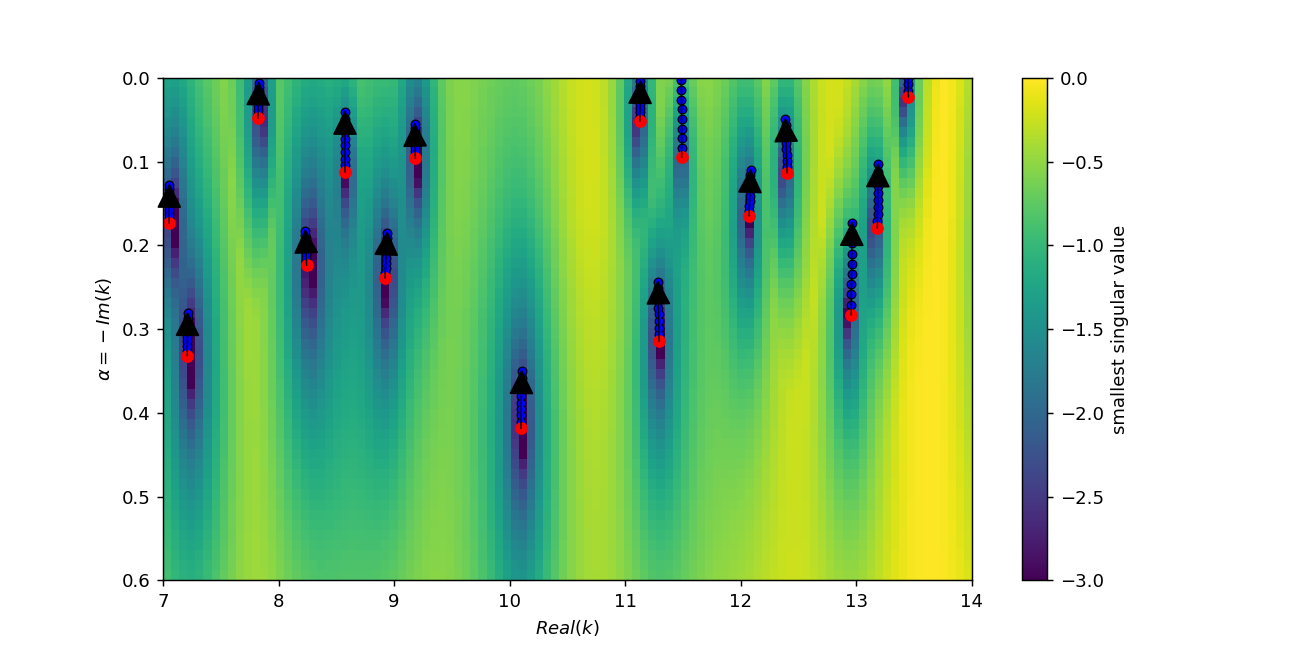

In [15]:
#plot the pump trajectories
plot_pump_traj(naq_u1, Ks, Alphas, s, modes, new_modes, estimate=True)

In [16]:
params['s_size']    = 1e-2*np.asarray([1.,1.])
params['max_steps'] = 2000
                        
th_modes, D0_th = naq_u1.full_lasing_threshold(modes, params, tol = 1e-4, D0_max = D0_max, D0_steps = D0_steps)

100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


<IPython.core.display.Javascript object>


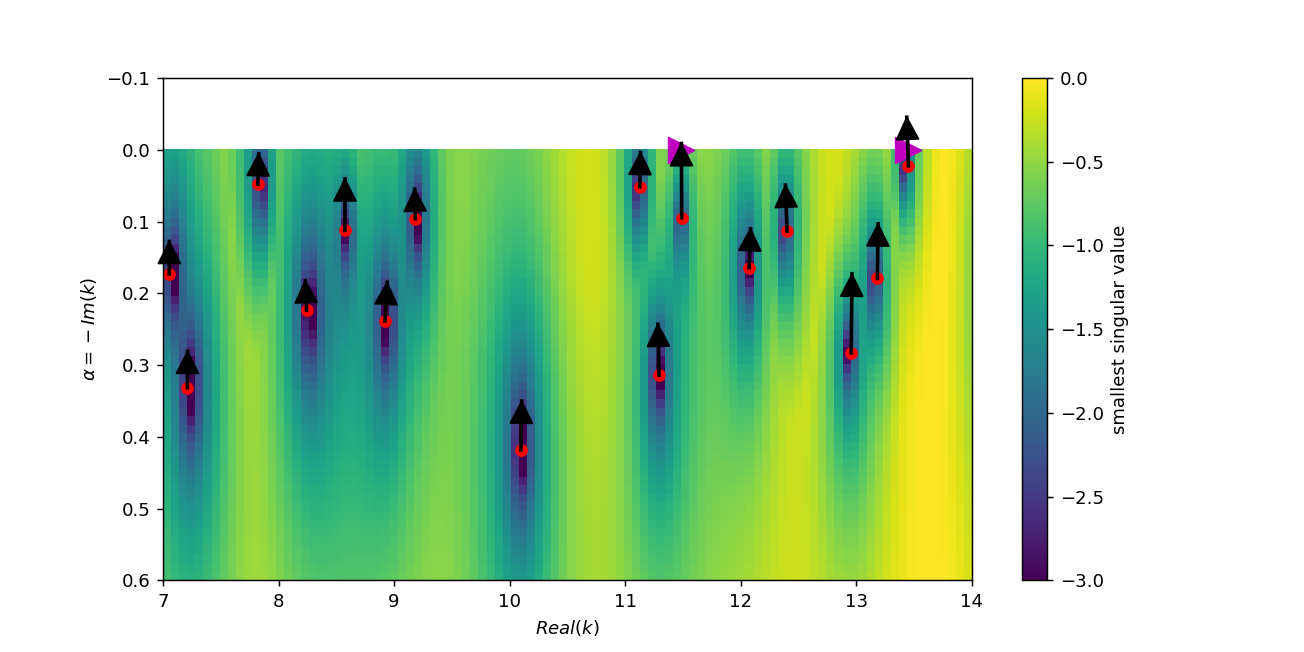

In [17]:
#plot the trajectories and the lasing modes

naq_u1.plot_pump_traj(  Ks, Alphas, s, modes, new_modes, estimate=False)
plt.axis([Ks[0], Ks[-1], Alphas[-1], -0.1])

for m in th_modes:
    if type(m) == np.ndarray:
        plt.scatter(m[0], m[1], marker = '>', s= 200, c='m')
#plt.axis([13.3, 13.5, 0.03, -0.01])
plt.show()

pickle.dump([th_modes, D0_th], open('threshold_modes.pkl', 'wb')) #save it for later

In [18]:
#create a smaller list of possible lasing modes out of all the passive modes 
# (remove the ones with -1 from the search above)

th_modes_selec = []
D0_th_selec = []
for i, m in enumerate(th_modes):
    if type(m) == np.ndarray:
        th_modes_selec.append(m)
        D0_th_selec.append(D0_th[i])
        
th_modes_selec = np.asarray(th_modes_selec)
D0_th_selec = np.asarray(D0_th_selec)
print(th_modes_selec)
print(D0_th_selec)

[[ 1.34475433e+01  3.36247190e-05]
 [ 1.14867209e+01 -2.28007221e-07]]
[0.00662501 0.01829765]


In [19]:
def compute_E2(self):
        """
        Compute the norm \int|E|^2 on each edge for normalisation later
        """
        
        phi = self.compute_solution()
        flux = self.Winv.dot(self.BT.T).dot(phi) #we use BT.T as we need to make sure the the in-fluxes vanish
        
        edge_mean = np.zeros(self.m)
        for ei, e in enumerate(list(self.graph.edges())):
            (u, v) = e[:2]
            if len(self.graph[u])>1 and len(self.graph[v])>1:

                z = np.zeros([2,2])
                if abs(np.real(self.graph[u][v]['chi']))>0: #if k has a complex part (recall \chi = ik)
                    z[0, 0] = 1.
                else: #we recast to real because it is real
                    z[0, 0] = np.real((np.exp( self.graph[u][v]['L']*(self.graph[u][v]['chi'] + np.conj(self.graph[u][v]['chi'])) ) - 1.)/self.graph[u][v]['L']*(self.graph[u][v]['chi'] + np.conj(self.graph[u][v]['chi'])) )

                #no issue here if im(k)=0, and just recast to real 
                z[0, 1] =  np.real(( np.exp( self.graph[u][v]['L']*self.graph[u][v]['chi'] ) - np.exp( self.graph[u][v]['L']*np.conj(self.graph[u][v]['chi'])) ) / (self.graph[u][v]['L']*( self.graph[u][v]['chi'] - np.conj(self.graph[u][v]['chi']) ) ))
            
                #other matrix elements
                z[1, 0] = z[0, 1]
                z[1, 1] = z[0, 0]
            
                #then compute the norm
                edge_mean[ei] = self.graph[u][v]['L']*np.real(np.conj(flux[2*ei:2*ei+2]).T.dot(z.dot(flux[2*ei:2*ei+2]))) #BUG flux est du mauvais type je crois, type(flux[2*ei:2*ei+2]): <class 'scipy.sparse.csc.csc_matrix'>
        
        #return the sqrt of the norm, i.e. \sqrt{ \int |E|^2 dx}
        return np.sqrt(edge_mean.sum())

In [20]:
def T_matrix(self, th_modes, D0_th):
            """
            Compute the T_{\mu\nu} matrix for nonlinear SALT
            """

            #first extract the flux vectors and Gammas
            fluxes = []
            gammas = []
            pump_norms = [] #collect the \int \delta_I E^2 for later
            n_modes = len(D0_th) #number of modes
            for i in range(n_modes):
                
                self.pump_params['D0'] = D0_th[i]
                
                self.update_chi(th_modes[i])
                self.update_laplacian()
                phi = self.compute_solution()

                    
                #normalize the modes first
                L0_in_norm = compute_E2(naq_u1)
                #phi /= L0_in_norm
                
                #compute the pump norm
                self.Z_matrix_U1() #compute the Z matrix
                edge_norm = self.Winv.dot(self.Z).dot(self.Winv) #compute the correct weight matrix
                L0_pump = self.BT.dot(edge_norm.dot(self.pump_mask)).dot(self.B).asformat('csc')
                
                pump_norms.append(phi.T.dot(L0_pump.dot(phi)))
                
                #compute the edge solution with correct normalisation
                flux = self.Winv.dot(self.BT.T).dot(phi)

                fluxes.append(flux)
                gammas.append(self.gamma)
                
            #populate the matrix, entry by entry (not a symmetric matrix!)
            T = np.zeros([n_modes, n_modes], dtype=np.complex64)
            for mu in range(n_modes):
                for nu in range(n_modes):
                    
                    #first set shorthand notations (following the notes)
                    lamb_mu = fluxes[mu]
                    lamb_nu = fluxes[nu]
                    
                    k_mu = (th_modes[mu][0]-1.j*th_modes[mu][1])*np.sqrt(1. + gammas[mu] * D0_th[mu])
                    k_nu = (th_modes[nu][0]-1.j*th_modes[nu][1])*np.sqrt(1. + gammas[nu] * D0_th[nu]) 
                    
                    Delta = k_nu - np.conj(k_nu)
                    Lamb  = k_nu + np.conj(k_nu)
                    
                    #compute the matrix element looping only on the pumped edges
                    for ei, e in enumerate(list(self.graph.edges())):
                        if ei in self.pump_params['edges']:
                            (u, v) = e[:2]

                            #shortand notation (as in the notes)
                            lamb_nu_plus = lamb_nu[2*ei]
                            lamb_nu_minus = lamb_nu[2*ei+1]
                            lamb_mu_plus = lamb_mu[2*ei]
                            lamb_mu_minus = lamb_mu[2*ei+1]
                            l = self.graph[u][v]['L']
                            
                            exp_term_1 = ( np.exp(1.j*(2*k_mu+Delta)*l) - 1. ) / (1.j*(2*k_mu+Delta))

                            T[mu, nu] += exp_term_1 * ( abs(lamb_nu_plus)**2*lamb_mu_plus**2  + 
                                                        abs(lamb_nu_minus)**2*lamb_mu_minus**2
                                                       )
                            
                            exp_term_2 = ( np.exp(2.j*k_mu*l) - np.exp(Delta*l) ) / (1.j*(2*k_mu-Delta))

                            T[mu, nu] += exp_term_2 * ( abs(lamb_nu_plus)**2*lamb_mu_minus**2 +
                                                        abs(lamb_nu_minus)**2*lamb_mu_plus**2 
                                                       )
                            
                            exp_term_3 = np.exp(1.j*k_mu*l)*(np.exp(1.j*Delta*l) - 1.) / (1.j*Delta) 
                            
                            T[mu, nu] += 2*exp_term_3 * ( abs(lamb_nu_plus)**2*lamb_mu_plus*lamb_mu_minus +
                                                          abs(lamb_nu_minus)**2*lamb_mu_plus*lamb_mu_minus
                                                        )
                            
                            exp_term_4 = ( np.exp(1.j*(2.*k_mu+k_nu)*l) 
                                          - np.exp(-1.j*np.conj(k_nu)*l) ) / (1.j*(2*k_nu+Lamb))
                            
                            T[mu, nu] += exp_term_4 * ( lamb_nu_plus*np.conj(lamb_nu_minus)*lamb_mu_plus**2 +
                                                        np.conj(lamb_nu_plus)*lamb_nu_minus*lamb_mu_minus**2
                                                      )
                            
                            exp_term_5 = ( np.exp(1.j*(2.*k_mu-np.conj(k_nu))*l) 
                                          - np.exp(1.j*k_nu*l) ) / (1.j*(2*k_nu-Lamb))
                            
                            T[mu, nu] += exp_term_5 * ( lamb_nu_plus*np.conj(lamb_nu_minus)*lamb_mu_minus**2 +
                                                       np.conj(lamb_nu_plus)*lamb_nu_minus*lamb_mu_plus**2
                                                      )
                        
                            exp_term_6 =   np.exp(1.j*k_mu*l) * ( np.exp(1.j*k_nu*l) 
                                                - np.exp(-1.j*np.conj(k_nu)*l) ) / (1.j*Lamb)
                                
                            T[mu, nu] += 2*exp_term_6 * ( lamb_nu_plus*np.conj(lamb_nu_minus)*lamb_mu_minus*lamb_mu_plus +
                                                        np.conj(lamb_nu_plus)*lamb_nu_minus*lamb_mu_minus*lamb_mu_plus
                                                      )
                    T[mu, nu] /= pump_norms[mu] #divide by the other integral \int \delta_i E^2
                    T[mu, nu] *= np.imag(-gammas[nu]) #finally multiply by \Gamma_\nu and use only the real part of T
            
            #print(np.real(T))
            #T = 0*np.real(T)+.22#/len(T)
            #T += np.diag(0.15*np.ones(len(T)))
            #if len(T)>1:
            #    T[1,0] = 0.01
            
            #T[0,0] = 0.8
            return np.real(T) #convert it to a array with real numbers
                                
T = T_matrix(naq_u1, th_modes_selec, D0_th_selec)
print(T)
print(np.linalg.inv(T))

[[0.20112003 0.10569714]
 [0.17128389 0.34087083]]
[[ 6.756375  -2.095015 ]
 [-3.3950047  3.9863849]]


In [23]:
def modal_intensities(self, D0_max, D0_steps, th_modes, D0_th):
    """
    compute the modal intensities of the modes up to D0, with D0_steps
    """
    D0_th = np.array(D0_th)
    th_modes = np.array(th_modes)
    
    n_modes = len(D0_th)
    
    D0s = np.linspace(0, D0_max, D0_steps)
    
    D0_th_min = np.min(D0_th) #smallest lasing threshold
    th_mode_first = th_modes[np.argmin(D0_th)] #first lasing mode
    
    D0_th_inv = 1./D0_th #inverse of lasing thresholds
    
    I = np.zeros([n_modes, D0_steps]) #collect the modal intensities
    lasing_modes = [] #ordered list of lasing modes ids
    
    next_D0 = D0_th_min #set the next lasing threshold to the minimum one 
    next_lasing_mode  = np.argmin(D0_th) #set the next lasing mode as the first to possibly lase
      
    for i, D0 in enumerate(D0s):
        print('D0', D0, 'next', next_D0)
        if D0 > D0_th_min: #before the first mode lases, nothing happens
            
            #while we can add new lasing modes, add them 
            search_new_lasing_modes = True 
            while search_new_lasing_modes:

                if D0 > next_D0: #if the next mode can be lased, add it and search the next one
                    lasing_modes += [next_lasing_mode,]
                    print('lasing modes', lasing_modes)


                    #if needed, compute all the interacting thresholds for the non-lasing modes
                    D0_ints = np.ones(n_modes)*1e5 #to collect the interacting thresholds, set them to large for later search of smallest
                    for mu in range(n_modes):
                        if mu not in lasing_modes:

                            #first compute the larger T matrix (including the mode m)
                            T_mu = T_matrix(self, th_modes[lasing_modes + [mu,]], D0_th_selec[lasing_modes + [mu,]])
                            T_mu_inv = np.linalg.inv(T_mu)

                            #compute the interacting threshold of mode m
                            D0_ints[mu] = 1./ ( T_mu_inv[-1].dot(D0_th_inv[lasing_modes + [mu,]]) / T_mu_inv[-1].dot( np.ones(len(lasing_modes)+1)) )
                            
                            D0_ints[mu] = np.real(D0_ints[mu])
                            
                    print(D0_ints, D0)
                    #next interacting threshold
                    next_D0 = np.min(np.real(D0_ints) )
                    next_lasing_mode = np.argmin(D0_ints)

                else: #if the next mode does not lase, stop the search and compute the modal intensities
                    search_new_lasing_modes = False
                    
            #update the T^{-1} matrix with new the new mode
            T_inv = np.linalg.inv(T_matrix(self, th_modes[lasing_modes], D0_th_selec[lasing_modes]))
            #print(T_matrix(self, th_modes[lasing_modes], D0_th_selec[lasing_modes]))
            #print(T_inv)
            #compute the modal intensities
            I[lasing_modes, i] = ( D0*T_inv.dot(D0_th_inv[lasing_modes]) - T_inv.sum(1) )
            #print(T_inv.dot(D0_th_inv[lasing_modes]),T_inv )
    return I

D0_steps = 100
D0_max = .03

I = modal_intensities(naq_u1, D0_max, D0_steps, th_modes_selec, D0_th_selec)

D0 0.0 next 0.006625013878900999
D0 0.00030303030303030303 next 0.006625013878900999
D0 0.0006060606060606061 next 0.006625013878900999
D0 0.0009090909090909091 next 0.006625013878900999
D0 0.0012121212121212121 next 0.006625013878900999
D0 0.0015151515151515152 next 0.006625013878900999
D0 0.0018181818181818182 next 0.006625013878900999
D0 0.002121212121212121 next 0.006625013878900999
D0 0.0024242424242424242 next 0.006625013878900999
D0 0.0027272727272727275 next 0.006625013878900999
D0 0.0030303030303030303 next 0.006625013878900999
D0 0.003333333333333333 next 0.006625013878900999
D0 0.0036363636363636364 next 0.006625013878900999
D0 0.00393939393939394 next 0.006625013878900999
D0 0.004242424242424242 next 0.006625013878900999
D0 0.004545454545454545 next 0.006625013878900999
D0 0.0048484848484848485 next 0.006625013878900999
D0 0.005151515151515152 next 0.006625013878900999
D0 0.005454545454545455 next 0.006625013878900999
D0 0.005757575757575757 next 0.006625013878900999
D0 0.0

<IPython.core.display.Javascript object>


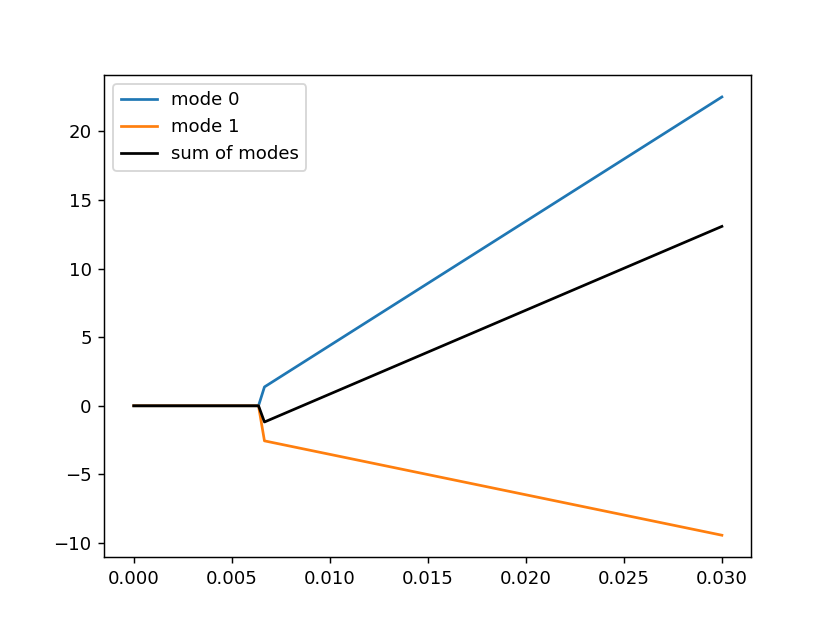

In [27]:
plt.figure()
D0s = np.linspace(0, D0_max, D0_steps)

for i in range(len(I)):
    plt.plot(D0s, (I[i]), '-', label='mode '+str(i))
    
plt.plot(D0s,I.sum(0),'-k',label='sum of modes')
plt.legend(loc='best')